In [1]:
# This notebook implements the examples from Lagaris 
# ["Lux", "NeuralPDE", "Zygote", "ModelingToolkit", "OrdinaryDiffEq", "LineSearches", "ProgressMeter", "Gnuplot", "Optimization", "OptimizationOptimJL", "OptimizationOptimisers"]
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using ProgressMeter
using Gnuplot
#gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics, ComponentArrays

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String ""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


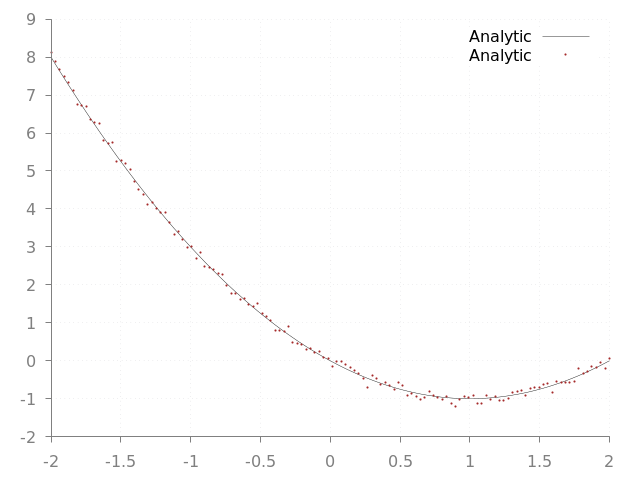

In [17]:
function generate_data(rng::AbstractRNG)
    x = reshape(collect(range(-2.0f0, 2.0f0, 128)), (1, 128)) 
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, (1, 128)) .* 0.1f0
    return (x, y)
end
rng = MersenneTwister()
Random.seed!(rng, 12345)
(x, y) = generate_data(rng)
y_analytic = evalpoly.(x, ((0, -2, 1),))

@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- vec(x) vec(y_analytic) "w l lw 0.4 lc 'black' t 'Analytic'"
@gp :- vec(x) vec(y) "with points pt 7 ps 0.2 lc 'brown' t 'Analytic'"

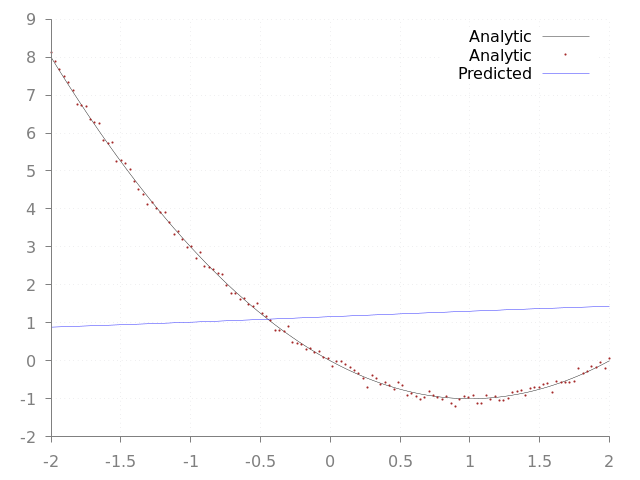

In [30]:
model = Chain(Dense(1 => 16, sigmoid), Dense(16 => 1)) 
ps, st = Lux.setup(rng, model)
ps = ps |> ComponentArray

y_pred = model(x, ps, st)[1] # forward pass

@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- vec(x) vec(y_analytic) "w l lw 0.4 lc 'black' t 'Analytic'"
@gp :- vec(x) vec(y) "with points pt 7 ps 0.2 lc 'brown' t 'Analytic'"
@gp :- vec(x) vec(y_pred) "w l lw 0.4 lc 'blue' t 'Predicted'"

In [31]:
#opt = Optimisers.Adam(0.03f0)
opt = Descent(0.0001)  
function loss_function(model, ps, st, data)
    y_pred, st = Lux.apply(model, data[1], ps, st)
    mse_loss = mean(abs2, y_pred .- data[2])
    return mse_loss, st, ()
end


loss_function (generic function with 1 method)

Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss
Epoch: epoch 	 Loss: loss


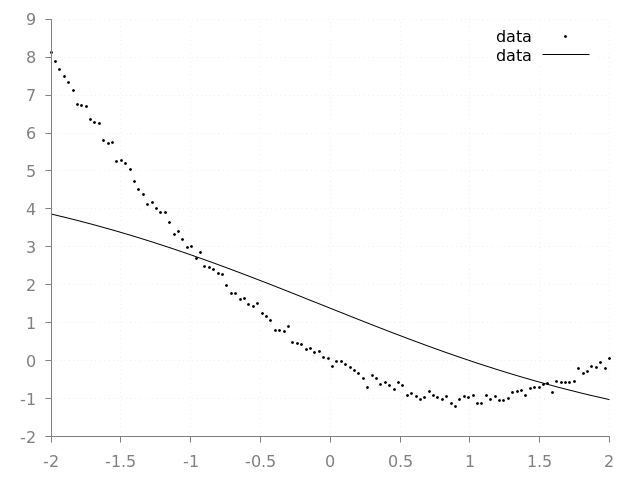

In [32]:
# training 
tstate = Lux.Experimental.TrainState(rng, model, opt)
vjp_rule = AutoZygote() # Reverse AD library -- Vector Jacobian Product

function train_model(tstate::Lux.Experimental.TrainState, vjp, data, epochs)
    for epoch in 1:epochs
        grads, loss, stats, tstate = Lux.Experimental.compute_gradients(
            vjp, loss_function, data, tstate)
        if epoch % 500 == 1 || epoch == epochs
            println("Epoch: epoch \t Loss: loss")
        end
        tstate = Lux.Experimental.apply_gradients!(tstate, grads)
    end
    return tstate
end
tstate = train_model(tstate, vjp_rule, (x, y), 10000)
y_pred = tstate.model(x, tstate.parameters, tstate.states)[1] # forward pass

@gp "reset" 
@gp :- "load '~/gpconfig.cfg'"
@gp :- vec(x) vec(y) "with points title 'data' ps 0.3 pt 7 lc 'black'"
@gp :- vec(x) vec(y_pred) "with lines title 'data' lc 'black'"